## Model Training to test

---


In [ ]:
# Libaries Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import DBSCAN

from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_error

from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix

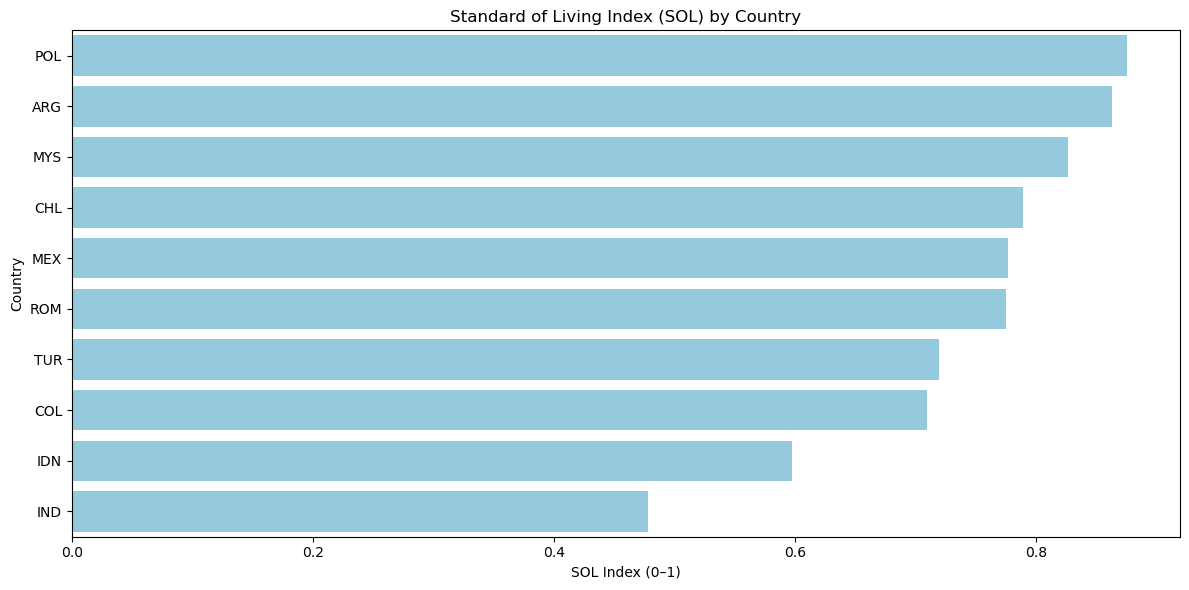

✅ Export complete! File saved as: SOL_Index_by_Country.xlsx


In [ ]:
# ======================================================
# 🌍 Standard of Living (SOL) Calculation (Clean Naming)
# ======================================================


# -----------------------------
# 1️⃣ LOAD DATA
# -----------------------------
df = pd.read_excel("Cleaned_Dataset.xlsx")  

# Detect country column
country_col = next((c for c in df.columns if str(c).lower().startswith('country')), None)
if not country_col:
    raise KeyError("No 'Country' column found.")

# Define columns used for SOL (excluding 'Improved water')
col_map = {
    'Primary completion rate, total (% of relevant age group)': 'education_rate',
    'Under-five mortality rate (per 1,000)': 'mortality_rate',
    'Physicians (per 1,000 people)': 'physicians_per_1k',
    'GNI per capita (Atlas $)': 'gni_per_capita',
    'Population living below $1.25 a day (% of total)': 'poverty_rate',
    'Paved roads (% of total roads)': 'paved_roads',
    'Access to improved sanitation (% of total pop.)': 'sanitation_rate'
}

missing_cols = [c for c in col_map if c not in df.columns]
if missing_cols:
    raise KeyError(f"Missing columns required for SOL calculation: {missing_cols}")

# Urban population handling
if 'Urban population (%)' in df.columns:
    df['urban_rate'] = df['Urban population (%)'].astype(float)
else:
    if 'Urban population' not in df.columns or 'Population' not in df.columns:
        raise KeyError("Missing urban population data.")
    df['urban_rate'] = (df['Urban population'].astype(float) /
                        df['Population'].replace(0, np.nan).astype(float)) * 100.0

# -----------------------------
# 2️⃣ COUNTRY-LEVEL MEANS
# -----------------------------
indicator_cols = list(col_map.keys()) + ['urban_rate']
country_means = (
    df.groupby(country_col)[indicator_cols]
    .mean(numeric_only=True)
    .reset_index()
    .rename(columns=col_map)
)

# Normalisation denominators
mortality_max = country_means['mortality_rate'].replace(0, np.nan).max() or 1
physicians_max = country_means['physicians_per_1k'].replace(0, np.nan).max() or 1

# -----------------------------
# 3️⃣ NORMALISED COMPONENTS
# -----------------------------
country_means['edu_index'] = country_means['education_rate'] / 100.0
country_means['health_index'] = 1.0 - (country_means['mortality_rate'] / mortality_max)
country_means['physicians_index'] = country_means['physicians_per_1k'] / physicians_max
country_means['income_index'] = country_means['gni_per_capita'] / 100.0
country_means['poverty_index'] = 1.0 - (country_means['poverty_rate'] / 100.0)
country_means['roads_index'] = country_means['paved_roads'] / 100.0
country_means['urban_index'] = country_means['urban_rate'] / 100.0
country_means['sanitation_index'] = country_means['sanitation_rate'] / 100.0

# Clip to [0,1] to avoid out-of-range values
index_cols = [
    'edu_index', 'health_index', 'physicians_index', 'income_index',
    'poverty_index', 'roads_index', 'urban_index', 'sanitation_index'
]
country_means[index_cols] = country_means[index_cols].clip(0, 1)

# -----------------------------
# 4️⃣ SOL INDEX CALCULATION
# -----------------------------
weights = {
    'edu_index': 0.15,
    'health_index': 0.15,
    'physicians_index': 0.10,
    'income_index': 0.15,
    'poverty_index': 0.10,
    'roads_index': 0.10,
    'urban_index': 0.05,
    'sanitation_index': 0.10
}

# Ensure weights sum to 1
total_weight = sum(weights.values())
weights = {k: v / total_weight for k, v in weights.items()}

# Weighted sum
country_means['sol_index'] = sum(country_means[col] * w for col, w in weights.items())

# -----------------------------
# 5️⃣ VISUALISE RESULTS
# -----------------------------
country_means_sorted = country_means.sort_values('sol_index', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='sol_index', y=country_col, data=country_means_sorted, color='skyblue')
plt.title("Standard of Living Index (SOL) by Country")
plt.xlabel("SOL Index (0–1)")
plt.ylabel("Country")
plt.tight_layout()
plt.show()

output_cols = [
    country_col,
    'education_rate', 'mortality_rate', 'physicians_per_1k', 'gni_per_capita',
    'poverty_rate', 'paved_roads', 'urban_rate', 'sanitation_rate',
    'edu_index', 'health_index', 'physicians_index', 'income_index',
    'poverty_index', 'roads_index', 'urban_index', 'sanitation_index',
    'sol_index'
]

# Create an output DataFrame
export_df = country_means[output_cols].copy()

# Export to a new Excel file
output_path = "SOL_Index_by_Country.xlsx"
export_df.to_excel(output_path, index=False)

print(f"✅ Export complete! File saved as: {output_path}")


In [ ]:
df = pd.read_excel("SOL_Index_by_Country.xlsx")

# Drop missing or irrelevant columns
df = df.dropna(subset=["sol_index"])
X = df.select_dtypes(include=["number"]).drop(columns=["sol_index"])
y = df["sol_index"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalise features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Random Forest Regressor

In [ ]:
rf = RandomForestRegressor(n_estimators=200)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)

print("Random forest - R²:", r2_score(y_test, y_pred_rf))
print("Random forest - MAE:", mean_absolute_error(y_test, y_pred_rf))

Random forest - R²: -4.24461972812905
Random forest - MAE: 0.016411596022672448


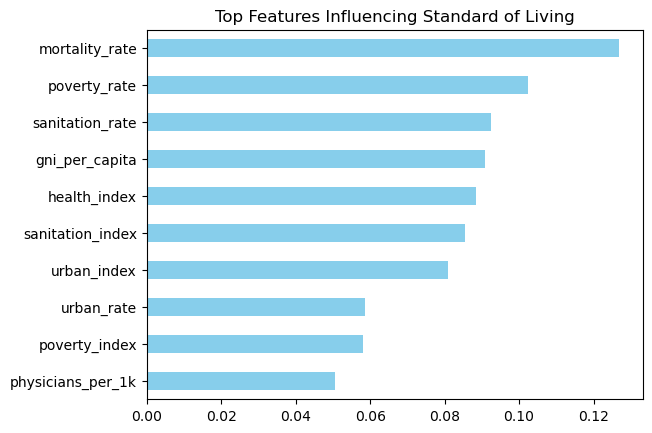

In [ ]:
feat_importance = pd.Series(rf.feature_importances_, index=X.columns)
feat_importance.nlargest(10).sort_values().plot(kind='barh', color='skyblue')
plt.title("Top Features Influencing Standard of Living")
plt.show()


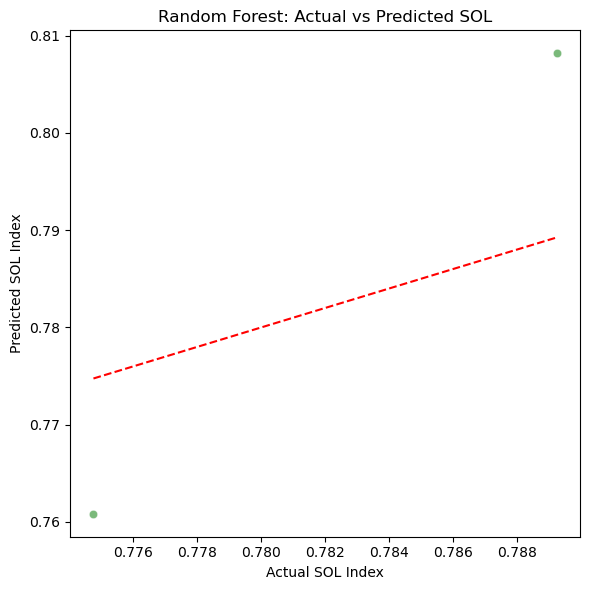

In [7]:


plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred_rf, color='forestgreen', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title("Random Forest: Actual vs Predicted SOL")
plt.xlabel("Actual SOL Index")
plt.ylabel("Predicted SOL Index")
plt.tight_layout()
plt.show()

## Decision Tree

Decision Tree — R²: -46.35791689157042
Decision Tree — MAE: 0.0484665419377035


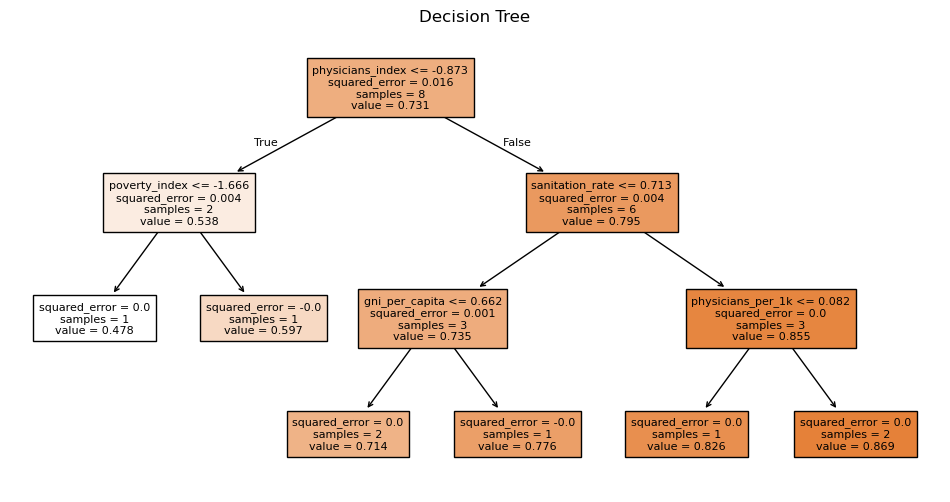

In [ ]:
dt = DecisionTreeRegressor(max_depth=3)
dt.fit(X_train_scaled, y_train)
y_pred_dt = dt.predict(X_test_scaled)

print("Decision Tree — R²:", r2_score(y_test, y_pred_dt))
print("Decision Tree — MAE:", mean_absolute_error(y_test, y_pred_dt))

# Plot (first 3 levels only for readability)
plt.figure(figsize=(12, 6))
plot_tree(dt, max_depth=3, feature_names=X.columns, filled=True, fontsize=8)
plt.title("Decision Tree")
plt.show()


## Gradient Boosting Regressor

In [ ]:
gbr = GradientBoostingRegressor()
gbr.fit(X_train_scaled, y_train)
y_pred_gbr = gbr.predict(X_test_scaled)

print("Gradient Boosting — R²:", r2_score(y_test, y_pred_gbr))
print("Gradient Boosting — MAE:", mean_absolute_error(y_test, y_pred_gbr))

Gradient Boosting — R²: -43.931806615651084
Gradient Boosting — MAE: 0.0484852946099526


## Linear Regression

In [ ]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

print("Linear Regression — R²:", r2_score(y_test, y_pred_lr))
print("Linear Regression — MAE:", mean_absolute_error(y_test, y_pred_lr))

Linear Regression — R²: 0.9898720911782295
Linear Regression — MAE: 0.0006858685216373228


## DBSCAN & PCA

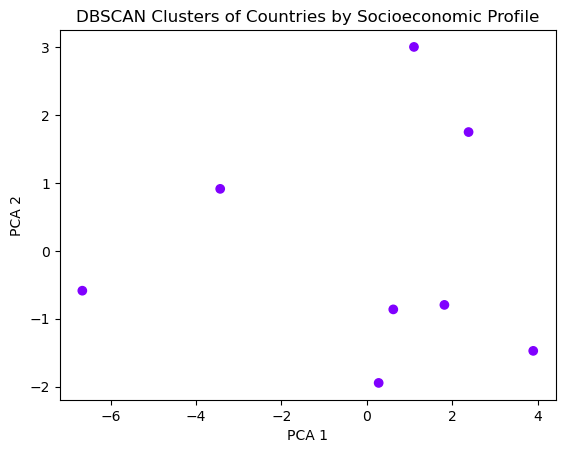

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)

db = DBSCAN(eps=0.5, min_samples=5).fit(X_pca)
plt.scatter(X_pca[:,0], X_pca[:,1], c=db.labels_, cmap='rainbow')
plt.title("DBSCAN Clusters of Countries by Socioeconomic Profile")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()


## Isolation Forest

In [ ]:
country_col = next((c for c in df.columns if str(c).lower().startswith('country')), None)
if not country_col:
    raise KeyError("No column starting with 'Country' found. Check df.columns output.")


X = df.select_dtypes(include=np.number).drop(columns=['sol_index'], errors='ignore')

# Standardise numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit Isolation Forest
iso = IsolationForest(contamination=0.1, random_state=42)
df['anomaly'] = iso.fit_predict(X_scaled)

# Label outliers
outliers = df[df['anomaly'] == -1]

print("⚠️ Countries performing unexpectedly (outliers):")
print(outliers[[country_col, 'sol_index']].head(10))


⚠️ Countries performing unexpectedly (outliers):
  Country code  sol_index
4          IND   0.478028


## Model Comparision

               Model         R²       MAE
3  Linear Regression   0.989872  0.000686
1      Random Forest  -4.244620  0.016412
2  Gradient Boosting -43.931807  0.048485
0      Decision Tree -46.357917  0.048467


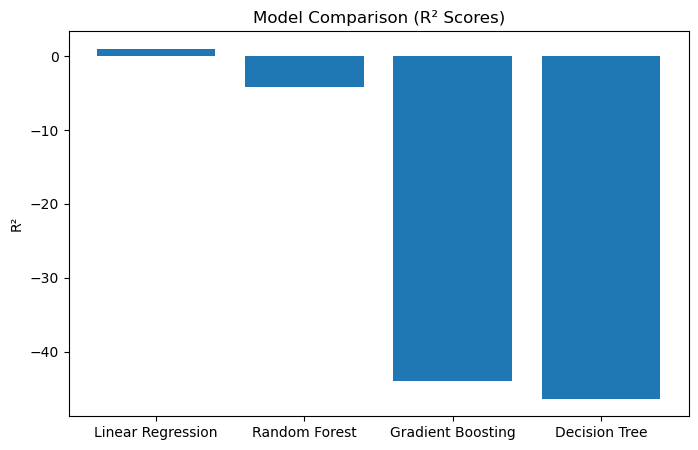

In [13]:
results = pd.DataFrame({
    'Model': ['Decision Tree', 'Random Forest', 'Gradient Boosting', 'Linear Regression'],
    'R²': [r2_score(y_test, y_pred_dt),
           r2_score(y_test, y_pred_rf),
           r2_score(y_test, y_pred_gbr),
           r2_score(y_test, y_pred_lr)],
    'MAE': [mean_absolute_error(y_test, y_pred_dt),
            mean_absolute_error(y_test, y_pred_rf),
            mean_absolute_error(y_test, y_pred_gbr),
            mean_absolute_error(y_test, y_pred_lr)]
}).sort_values('R²', ascending=False)

print(results)

plt.figure(figsize=(8,5))
plt.bar(results['Model'], results['R²'])
plt.title("Model Comparison (R² Scores)")
plt.ylabel("R²")
plt.show()

In [14]:


df = pd.read_excel("check.xlsx")

# Detect key columns automatically
country_col = next((c for c in df.columns if str(c).lower().startswith('country')), None)
year_col = next((c for c in df.columns if 'year' in str(c).lower()), None)
print(f"Detected: {country_col}, {year_col}")

# Required columns mapping (adjust names if needed)
cols = {
    'Primary completion rate, total (% of relevant age group)': 'primary',
    'Under-five mortality rate (per 1,000)': 'under5',
    'Physicians (per 1,000 people)': 'physicians',
    'GNI per capita (Atlas $)': 'gni',
    'Population living below $1.25 a day (% of total)': 'poverty',
    'Paved roads (% of total roads)': 'paved_roads',
    'Urban population': 'urban_pop',
    'Access to improved sanitation (% of total pop.)': 'sanitation'
}

missing = [c for c in cols if c not in df.columns]
if missing:
    raise KeyError(f"Missing columns: {missing}")

df = df.rename(columns=cols)

mort_max = df['under5'].replace(0, np.nan).max() or 1.0
phys_max = df['physicians'].replace(0, np.nan).max() or 1.0

df['E']   = df['primary'] / 100
df['H']   = 1 - (df['under5'] / mort_max)
df['P']   = df['physicians'] / phys_max
df['I']   = df['gni'] / 100
df['Pov'] = 1 - (df['poverty'] / 100)
df['R']   = df['paved_roads'] / 100
df['U']   = df['urban_pop'] / 100
df['S']   = df['sanitation'] / 100


for col in ['E','H','P','I','Pov','R','U','S']:
    df[col] = df[col].clip(0,1)

weights = {'E':0.15,'H':0.15,'P':0.10,'I':0.15,'Pov':0.10,'R':0.10,'U':0.05,'S':0.10}
df['SOL_index'] = sum(df[k]*w for k,w in weights.items())

print(df[[country_col, year_col, 'SOL_index']].head())


Detected: Country code, Year
  Country code  Year  SOL_index
0          ARG  1990   0.766711
1          ARG  1991   0.768411
2          ARG  1992   0.769849
3          ARG  1993   0.770662
4          ARG  1994   0.771606


In [15]:
X = df.select_dtypes(include=np.number).drop(columns=['SOL_index'], errors='ignore')
y = df['SOL_index']


In [16]:


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [17]:
y_class = pd.qcut(y, q=[0, 1/3, 2/3, 1], labels=['Low','Medium','High'])

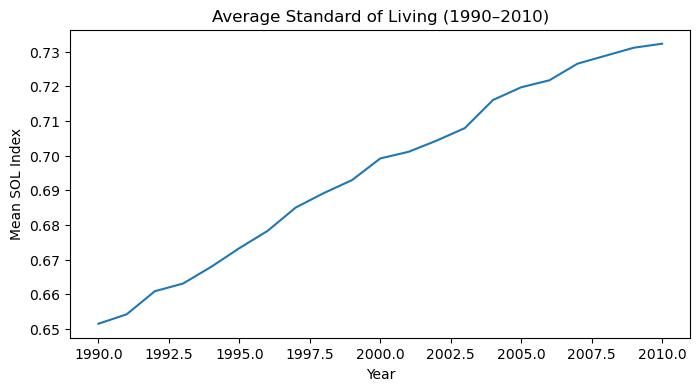

In [18]:

df.groupby(year_col)['SOL_index'].mean().plot(figsize=(8,4))
plt.title("Average Standard of Living (1990–2010)")
plt.xlabel("Year")
plt.ylabel("Mean SOL Index")
plt.show()


## Gaussian Naive Bayes


=== Gaussian Naive Bayes Classification Report ===
              precision    recall  f1-score   support

         Low       1.00      0.79      0.88        14
      Medium       0.82      1.00      0.90        14
        High       1.00      1.00      1.00        14

    accuracy                           0.93        42
   macro avg       0.94      0.93      0.93        42
weighted avg       0.94      0.93      0.93        42



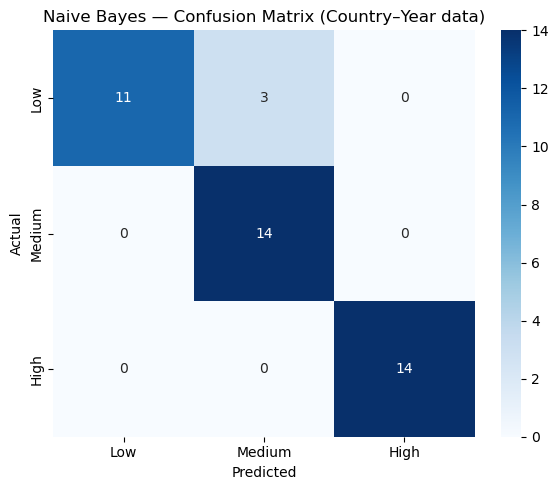

In [19]:
# ============================================================
# 🌍 Classification with Gaussian Naive Bayes (RAW DATA)
# ============================================================



# -------------------------------
# 1️⃣ Features (X) and Target (y)
# -------------------------------
X = df.select_dtypes(include=np.number).drop(columns=['SOL_index'], errors='ignore')
y = df['SOL_index']

# Create Low / Medium / High categories
y_class = pd.qcut(y, q=[0, 1/3, 2/3, 1],
                  labels=['Low', 'Medium', 'High'],
                  duplicates='drop')

# Drop rows with NaN labels
mask = y_class.notna()
X, y_class = X.loc[mask], y_class.loc[mask]
# -------------------------------
# Handle missing values
# -------------------------------
# Fill missing numeric values with column mean (safer than dropping rows)
X = X.fillna(X.mean(numeric_only=True))

# -------------------------------
# 2️⃣ Split + Scale
# -------------------------------
X_train, X_test, y_train_cls, y_test_cls = train_test_split(
    X, y_class, test_size=0.2, random_state=42, stratify=y_class
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# -------------------------------
# 3️⃣ Train Naive Bayes
# -------------------------------
gnb = GaussianNB()
gnb.fit(X_train_scaled, y_train_cls)
y_pred = gnb.predict(X_test_scaled)

# -------------------------------
# 4️⃣ Evaluation
# -------------------------------
labels = ['Low', 'Medium', 'High']
print("\n=== Gaussian Naive Bayes Classification Report ===")
print(classification_report(y_test_cls, y_pred, labels=labels, zero_division=0))

cm = confusion_matrix(y_test_cls, y_pred, labels=labels)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title("Naive Bayes — Confusion Matrix (Country–Year data)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()
